<a href="https://colab.research.google.com/github/cogilv25/21010093uhi_DataAnalytics/blob/main/2%20-%20Model%20Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Generation Using TensorFlow
## Initialization
The dataset and neccessary modules are imported.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib as matplot
from matplotlib import pyplot as plot
from matplotlib import patches as patches

df = pd.read_csv("https://raw.githubusercontent.com/cogilv25/21010093uhi_DataAnalytics/refs/heads/main/2_cleaned_dataset.csv", index_col=0)

In [2]:
def generate_train_and_test_sets(dataframe, label_name, feature_list, split = 0.8):
  dataset = [dataframe[label_name]]
  for f in feature_list:
    dataset.append(dataframe[f])
  keys =  feature_list.copy()
  keys.insert(0, label_name)

  dataset = pd.concat(dataset, axis=1, keys=keys)

  trainset = dataset.sample(frac=split, random_state=0)
  testset = dataset.drop(trainset.index)

  return trainset, testset

# Note: It is assumed generate_train_and_test_sets was used to generate the training set input to this function.
def generate_and_train_linear_model(trainset, epochs = 100, learning_rate = 0.1):
  features = trainset.copy()
  labels = features.pop(features.keys()[0]) # generate_train_and_test_sets puts the label in the first column.

  normaliser = tf.keras.layers.Normalization(axis=-1)
  normaliser.adapt(np.array(features))

  model = tf.keras.Sequential([normaliser, layers.Dense(units=1)])

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss="mean_absolute_error")

  model.fit(features, labels, epochs=epochs, verbose=0, validation_split=0.2)

  return model

# Note: It is assumed generate_train_and_test_sets was used to generate the training set input to this function.
def get_model_predictions_and_actual(model, testset):
  features = testset.copy()
  actual = features.pop(features.keys()[0]) # generate_train_and_test_sets puts the label in the first column.
  return model.predict(features, verbose=0).flatten(), actual

def evaluate_predicted_versus_actual(predicted, actual, nFeatures):
  error = actual - predicted
  error_squared = error ** 2
  total_variation_squared = (actual - actual.mean()) ** 2
  nObservations = actual.count()

  mae = abs(error).mean()                                                       # Mean Absolute Error
  rmse = np.sqrt(error_squared.mean())                                          # Root Mean Error Squared
  rsq = 1 - (error_squared.sum() / total_variation_squared.sum())               # R-Squared
  arsq = 1 - ((1 - rsq) * (nObservations-1)) / (nObservations - nFeatures - 1)  # Adjusted R-Squared

  return mae, rmse, rsq, arsq

def print_evaluation_statistics(mae, rmse, rsq, arsq):
  print("Mean Absolute Error:", mae)
  print("Root Mean Squared Error:", rmse)
  print("R-Squared:", rsq)
  print("Adjusted R-Squared:", arsq)

def plot_predicted_versus_actual(predicted, actual):
  plot.figure(figsize=(8,6))
  plot.scatter(actual,predicted, label="Predicted")
  plot.xlabel("Actual")
  plot.ylabel("Prediction")
  plot.title("Actual vs. Prediction")
  plot.plot([actual.min(), actual.max()],[actual.min(), actual.max()], color="red")
  legend_patch = patches.Patch(color='red', label='Prediction = Actual')
  plot.legend(handles=[legend_patch])
  plot.show()

def plot_training_versus_validation_loss(train, valid, epochs):
  epoch_axis = range(epochs)
  plot.figure(figsize=(8,6))
  plot.plot(epoch_axis, train, label="Training Loss", color="blue")
  plot.plot(epoch_axis, valid, label="Validation Loss", color="red")
  plot.title("Training Loss vs. Validation Loss")
  plot.show()


## Mean Performance
To give a baseline a plot is generated where the predicted value is the mean. Evaluation statistics are also generated. R-Squared is undefined here as total variation squared is 0 and dividing by 0 is undefined. We can think of this as a zero as the model explains none of the variation from the mean by assuming the output is always the mean.

---
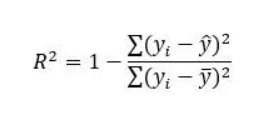
---
In our case this resolves to R-Squared = 1 - 0 / 0

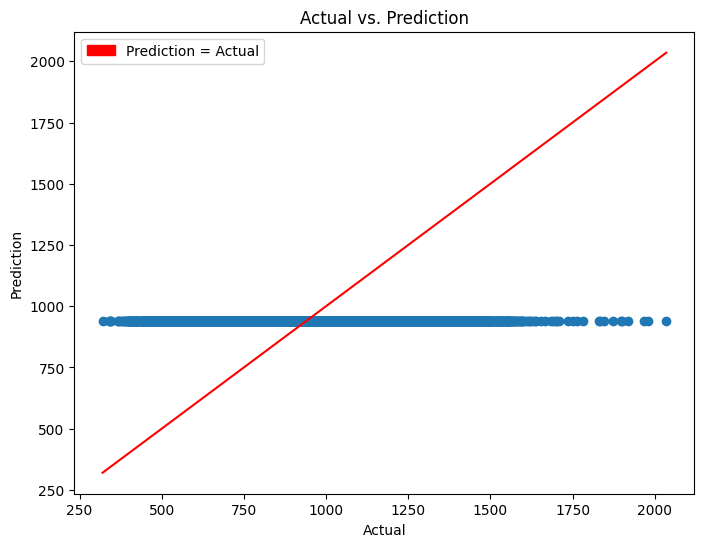

Mean Absolute Error: 245.31394440441954
Root Mean Squared Error: 281.5786107324431
R-Squared: Undefined
Adjusted R-Squared: Undefined


In [4]:
mean_reports = df['reports'].mean()
mean_model_predictions = pd.DataFrame({"reports":[mean_reports]*(df['reports'].count())})

plot.figure(figsize=(8,6))
plot.scatter(df['reports'],mean_model_predictions, label="Predicted")
plot.xlabel("Actual")
plot.ylabel("Prediction")
plot.title("Actual vs. Prediction")
plot.plot([df['reports'].min(), df['reports'].max()],[df['reports'].min(), df['reports'].max()], color="red")
legend_patch = patches.Patch(color='red', label='Prediction = Actual')
plot.legend(handles=[legend_patch])
plot.show()


mean_model_mae = 0
mean_model_rmse = 0
for i in df['reports']:
  mean_model_mae += abs(mean_reports - i)                            # Calculate Absolute Error
  mean_model_rmse += (mean_reports - i) ** 2                         # Calculate Square Error

mean_model_mae /= df['reports'].count()                              # Convert to Mean Absolute Error
mean_model_rmse = np.sqrt(mean_model_rmse / df['reports'].count())   # Convert to Root Mean Error Squared

print("Mean Absolute Error:", mean_model_mae)
print("Root Mean Squared Error:", mean_model_rmse)
print("R-Squared: Undefined")
print("Adjusted R-Squared: Undefined")

## Linear Regression
Year has a very high correlation with reports to the point that the effect of other features is difficult to see in graphs when single feature linear models are created as shown by comparing year and temperature (the second highest correlating feature):

### Year

CPU times: user 48.8 s, sys: 2.2 s, total: 51 s
Wall time: 58.6 s


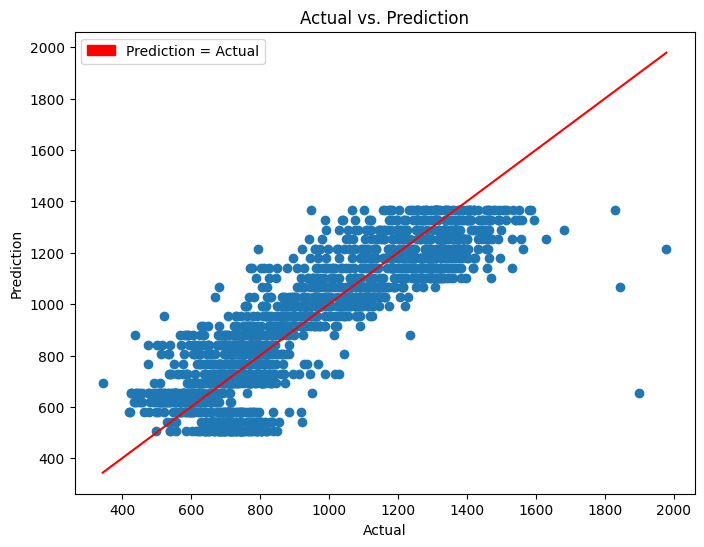

Mean Absolute Error: 109.2767982308723
Root Mean Squared Error: 140.15364043625593
R-Squared: 0.7466122577033774
Adjusted R-Squared: 0.7464674647077794


In [5]:
trainset, testset = generate_train_and_test_sets(df,"reports",["year"])

model_year = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_year, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Temperature

CPU times: user 48.6 s, sys: 2.17 s, total: 50.8 s
Wall time: 1min


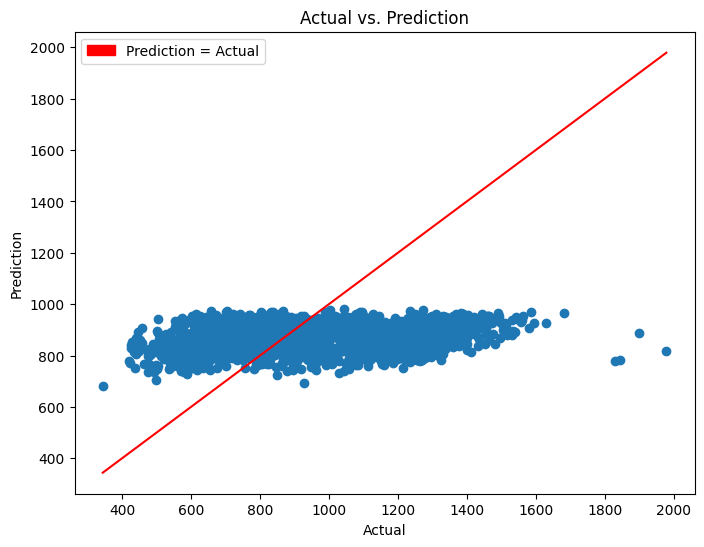

Mean Absolute Error: 233.46240958993295
Root Mean Squared Error: 278.20007392165724
R-Squared: 0.0016304692560320522
Adjusted R-Squared: 0.0010599723813212725


In [6]:
trainset, testset = generate_train_and_test_sets(df,"reports",["temp"])

model_temp = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_temp, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

To better show the effect of other features the predicted values generated by the year model are subtracted from the dataset and then all models are generated for each feature on this new dataset. Graphs of actual versus predicted reports and evaluation statistics are generated for each model.

In [7]:
predictions, actual = get_model_predictions_and_actual(model_year, df[['reports',"year"]])

year_adjusted_dataset = df.copy()
year_adjusted_dataset['reports'] -= predictions

### Month

CPU times: user 51.7 s, sys: 2.29 s, total: 54 s
Wall time: 1min 2s


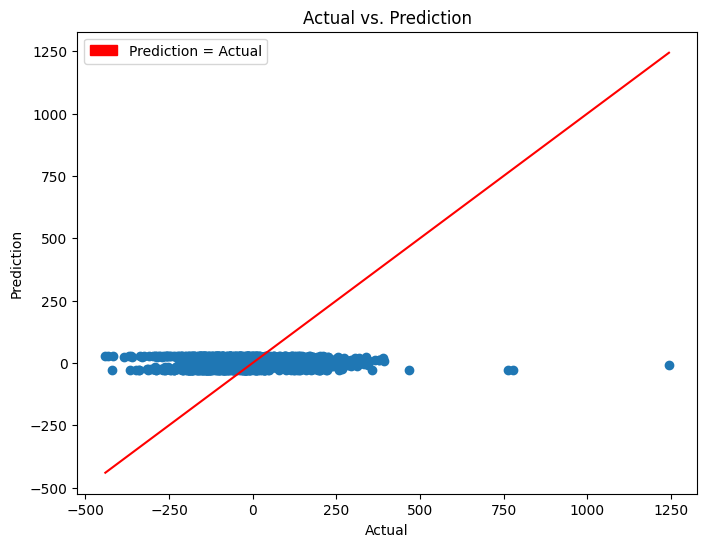

Mean Absolute Error: 108.28141648570697
Root Mean Squared Error: 139.64691064743562
R-Squared: 0.0043141795481008716
Adjusted R-Squared: 0.0037452162221283114


In [8]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["month"])

model_month = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_month, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Day Of Month

CPU times: user 51.7 s, sys: 2.29 s, total: 54 s
Wall time: 1min 6s


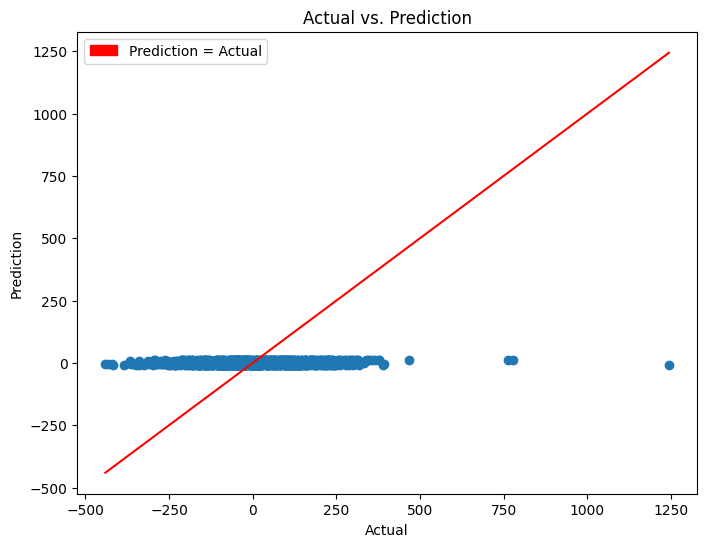

Mean Absolute Error: 109.19232422875487
Root Mean Squared Error: 139.80894512594708
R-Squared: 0.002002219592331933
Adjusted R-Squared: 0.001431935146384733


In [9]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["dayOfMonth"])

model_dotm = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_dotm, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Day Of Week

CPU times: user 51.4 s, sys: 2.26 s, total: 53.7 s
Wall time: 1min 4s


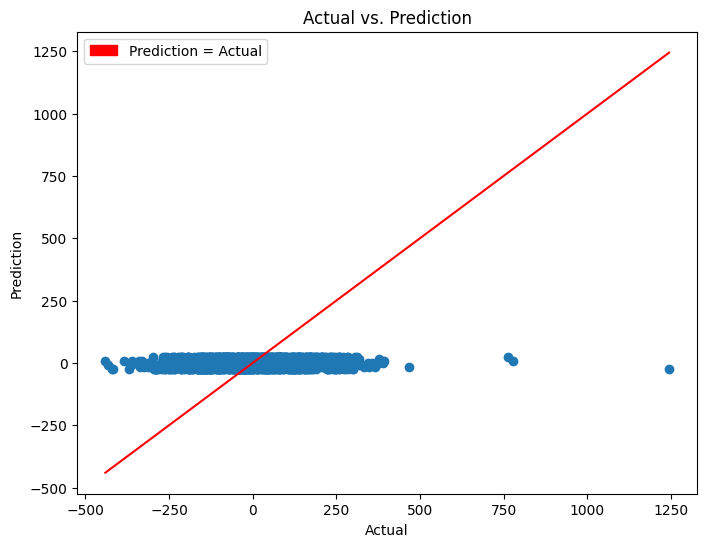

Mean Absolute Error: 108.51963502059789
Root Mean Squared Error: 139.24839562575505
R-Squared: 0.009988914203964971
Adjusted R-Squared: 0.00942319358351007


In [10]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["dayOfWeek"])

model_dotw = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_dotw, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Temperature

CPU times: user 50.7 s, sys: 2.31 s, total: 53.1 s
Wall time: 1min


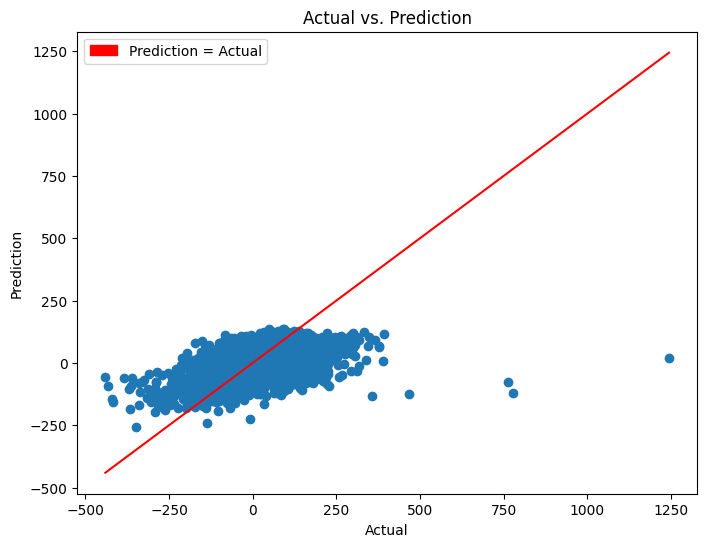

Mean Absolute Error: 88.75402760260725
Root Mean Squared Error: 118.26556777809039
R-Squared: 0.2858716081807233
Adjusted R-Squared: 0.28546353481396947


In [11]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["temp"])

model_temp = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_temp, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Maximum Temperature

CPU times: user 49.9 s, sys: 2.2 s, total: 52.1 s
Wall time: 1min 1s


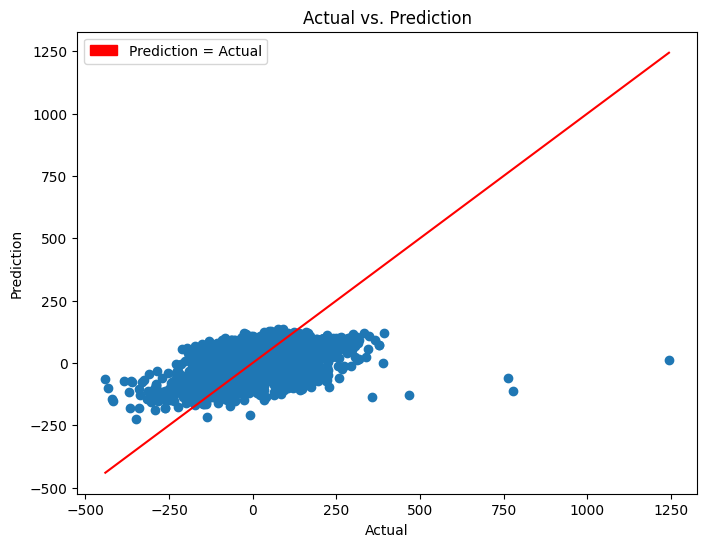

Mean Absolute Error: 89.58071719906101
Root Mean Squared Error: 119.01417565038662
R-Squared: 0.27680228847911315
Adjusted R-Squared: 0.2763890326439584


In [12]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["max"])

model_max = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_max, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Minimum Temperature

CPU times: user 51.4 s, sys: 2.27 s, total: 53.7 s
Wall time: 1min 3s


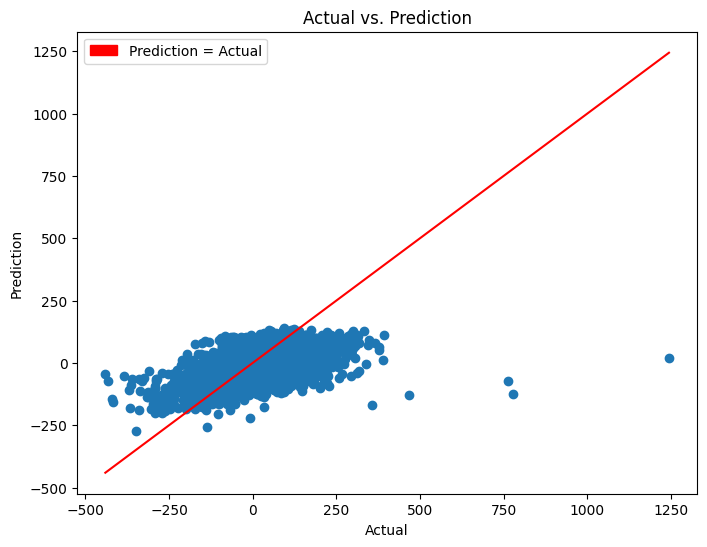

Mean Absolute Error: 88.9912575901099
Root Mean Squared Error: 119.04066018893907
R-Squared: 0.2764803824756812
Adjusted R-Squared: 0.2760669426942387


In [13]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["min"])

model_min = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_min, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Dew Point

CPU times: user 53 s, sys: 2.39 s, total: 55.4 s
Wall time: 1min 4s


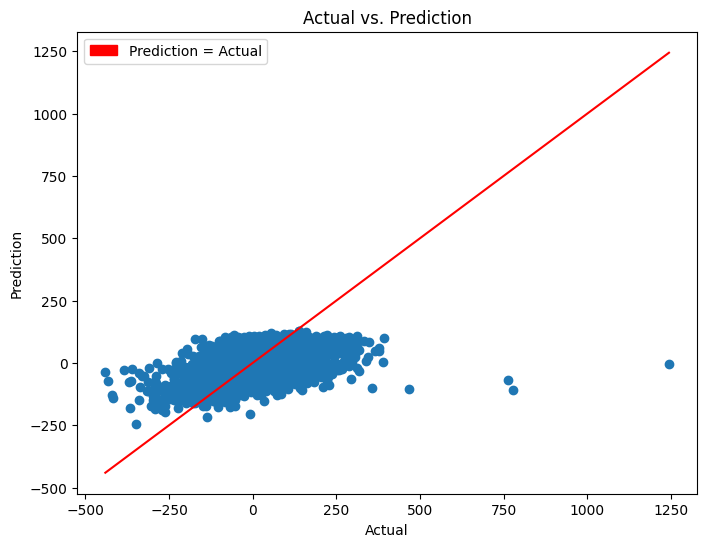

Mean Absolute Error: 91.59559035668634
Root Mean Squared Error: 122.06248454699583
R-Squared: 0.23928134093581077
Adjusted R-Squared: 0.23884664455920257


In [14]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["dewp"])

model_dewp = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_dewp, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Sea Level Pressure

CPU times: user 52.4 s, sys: 2.45 s, total: 54.9 s
Wall time: 1min 4s


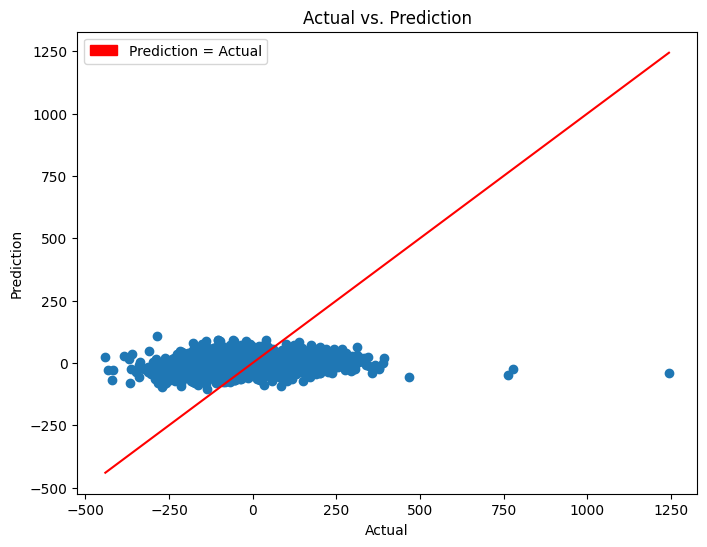

Mean Absolute Error: 106.15862074382093
Root Mean Squared Error: 137.72371930904592
R-Squared: 0.03155013560396136
Adjusted R-Squared: 0.030996735681449228


In [15]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["slp"])

model_slp = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_slp, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Wind Speed

CPU times: user 51.4 s, sys: 2.26 s, total: 53.7 s
Wall time: 1min


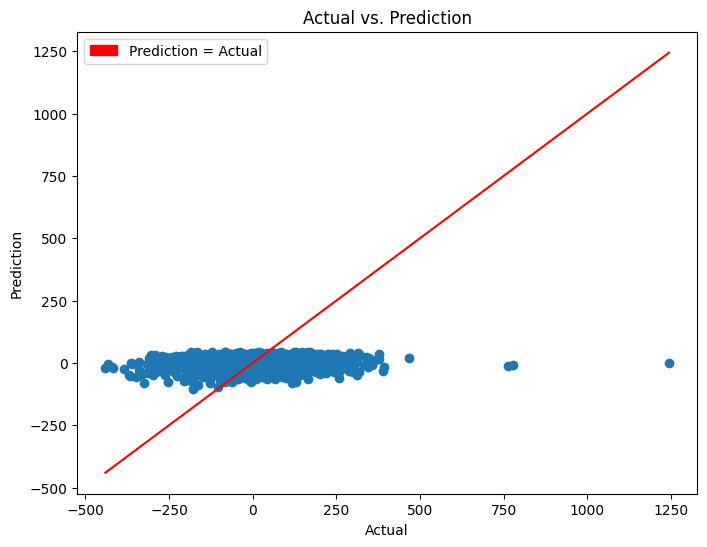

Mean Absolute Error: 107.59308288168145
Root Mean Squared Error: 138.44245751376064
R-Squared: 0.02141566946961926
Adjusted R-Squared: 0.020856478423601943


In [16]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["wdsp"])

model_wdsp = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_wdsp, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Maximum Wind Speed

CPU times: user 53.2 s, sys: 2.43 s, total: 55.7 s
Wall time: 1min 3s


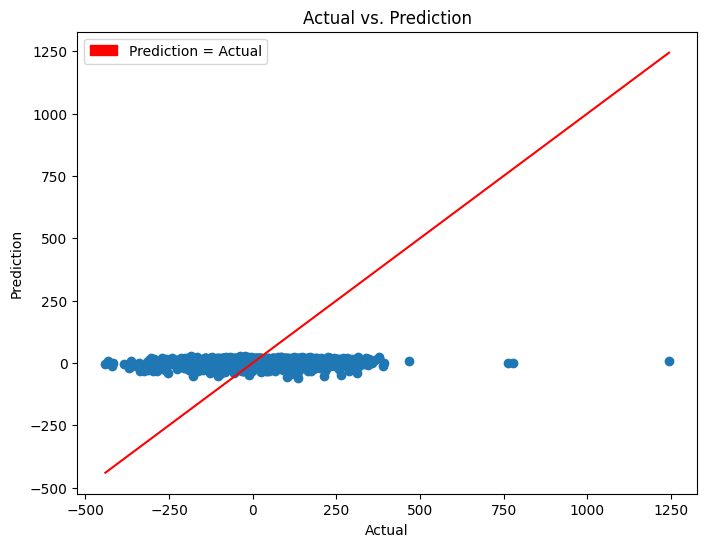

Mean Absolute Error: 108.67473203440507
Root Mean Squared Error: 139.62253729808054
R-Squared: 0.004661714347197643
Adjusted R-Squared: 0.004092949612538921


In [17]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["mxpsd"])

model_mxpsd = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_mxpsd, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Total Precipitation

CPU times: user 52 s, sys: 2.32 s, total: 54.3 s
Wall time: 1min 1s


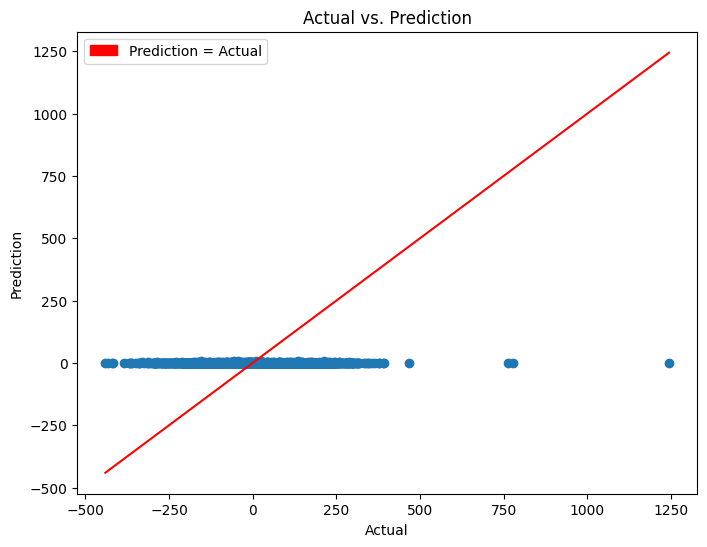

Mean Absolute Error: 109.2992333567544
Root Mean Squared Error: 140.14567769802795
R-Squared: -0.002810964010224737
Adjusted R-Squared: -0.003383998846802072


In [18]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["prcp"])

model_prcp = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_prcp, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Snow Depth

CPU times: user 51.9 s, sys: 2.32 s, total: 54.2 s
Wall time: 1min 1s


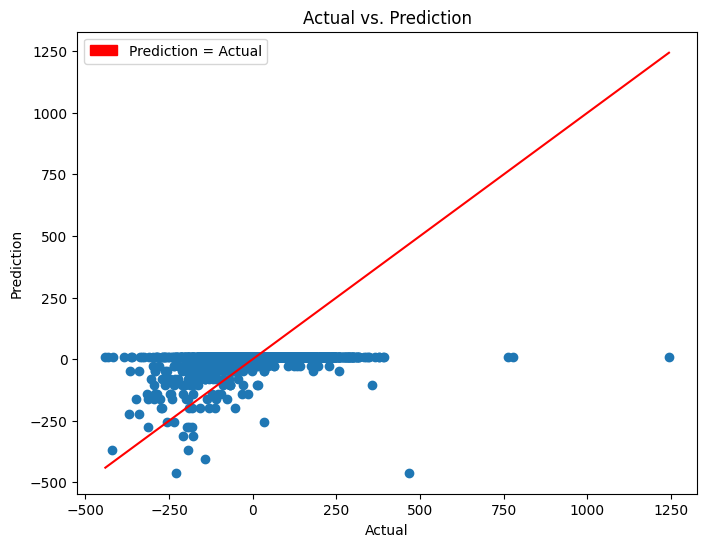

Mean Absolute Error: 103.31624090562673
Root Mean Squared Error: 133.84853200951824
R-Squared: 0.0852827223198156
Adjusted R-Squared: 0.08476002673256966


In [19]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["sndp"])

model_sndp = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_sndp, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Visibility

CPU times: user 51.9 s, sys: 2.36 s, total: 54.3 s
Wall time: 1min 4s


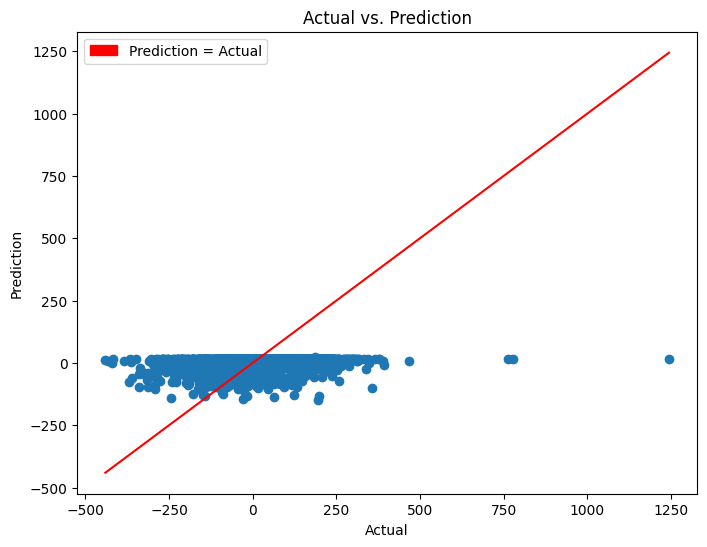

Mean Absolute Error: 106.80889280718756
Root Mean Squared Error: 137.154739923079
R-Squared: 0.03953553968927026
Adjusted R-Squared: 0.03898670285480699


In [20]:
trainset, testset = generate_train_and_test_sets(year_adjusted_dataset,"reports",["visib"])

model_visib = %time generate_and_train_linear_model(trainset)

predictions, actual = get_model_predictions_and_actual(model_visib, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 1)
)

### Finding the Best Model

Temperature, maximum temperature, minimum temperature, dew point and snow depth make reasonable improvements to the model, total precipitation causes the model to perform worse than when it is excluded, and every other feature makes small improvements to the model. Trial and error guided by these results will be used to find the best performing model configuration that uses any combination of the features.

CPU times: user 5min 9s, sys: 13.8 s, total: 5min 23s
Wall time: 6min 18s


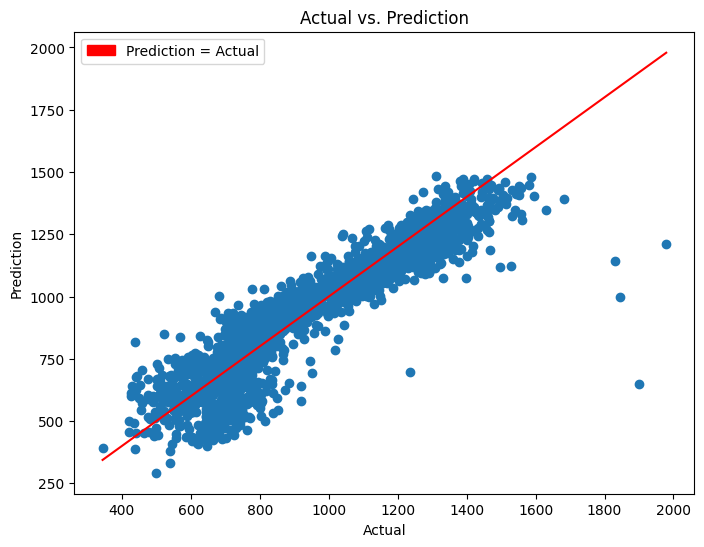

Mean Absolute Error: 85.93239912268234
Root Mean Squared Error: 114.67908232653001
R-Squared: 0.8303533632232645
Adjusted R-Squared: 0.829476888061961


In [21]:
trainset, testset = generate_train_and_test_sets(df,"reports",["year", "temp", "min", "sndp", "wdsp", "visib", "dayOfWeek", "month", "dayOfMonth"])

final_model = %time generate_and_train_linear_model(trainset, 600, 0.01)

train_loss = final_model.history.history['loss']
valid_loss = final_model.history.history['val_loss']
epochs = range(len(train_loss))

predictions, actual = get_model_predictions_and_actual(final_model, testset)
plot_predicted_versus_actual(predictions, actual)
print_evaluation_statistics(
    *evaluate_predicted_versus_actual(predictions, actual, 9)
)

The final model configuration uses year, month, day of the month, day of the week, temperature, snow depth, minimum temperature, mean wind speed and visibility. 600 epochs and a learning rate of 0.01 was found to be optimal for producing the best model.

To find a reasonable best model using this configuration the training and test datasets are generated 25 times and models are trained, statistics are compared to select the best model.



Best Model:


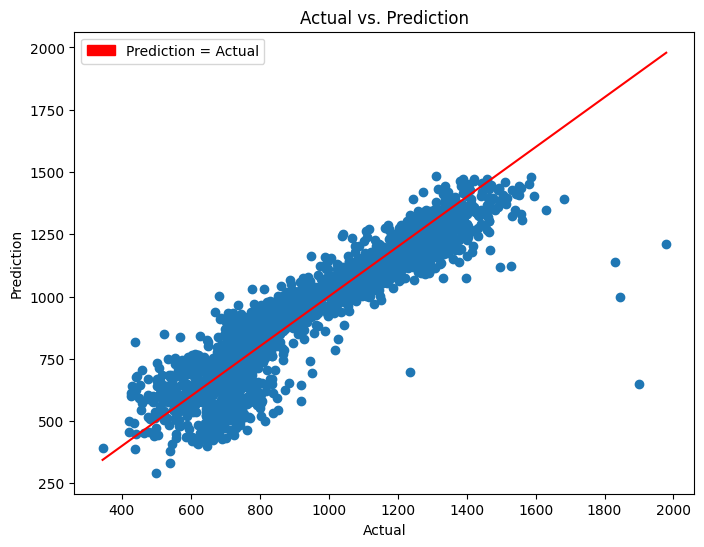

Mean Absolute Error: 85.91506496412025
Root Mean Squared Error: 114.65940752383976
R-Squared: 0.8304115687428387
Adjusted R-Squared: 0.8295353942989154


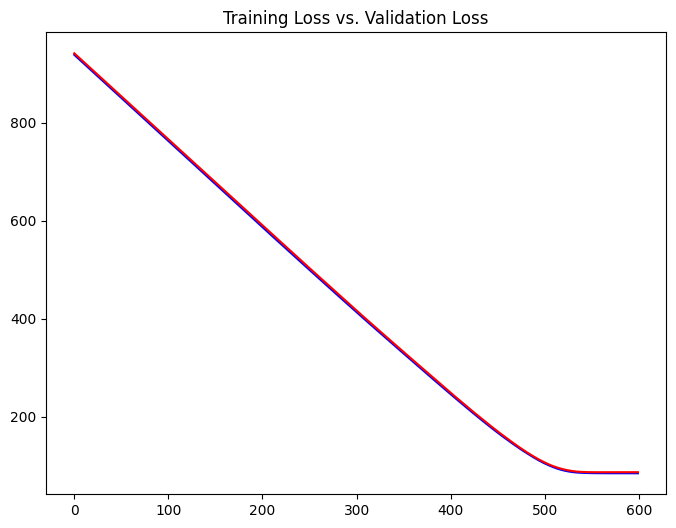

CPU times: user 2h 7min 35s, sys: 6min 5s, total: 2h 13min 41s
Wall time: 2h 33min 2s


In [5]:
%%time
epochs = 600
learning_rate = 0.01

bestModel = 0
bestStats = [9999,0,0,0]
bestTrainLoss = 0
bestValidLoss = 0
bestPredictions = 0
bestActual = 0

for i in range(25):
  trainset, testset = generate_train_and_test_sets(df,"reports",["year", "temp", "min", "sndp", "wdsp", "visib", "dayOfWeek", "month", "dayOfMonth"])

  model = generate_and_train_linear_model(trainset, epochs, learning_rate)

  trainLoss = model.history.history['loss']
  validLoss = model.history.history['val_loss']

  predictions, actual = get_model_predictions_and_actual(model, testset)

  stats = evaluate_predicted_versus_actual(predictions, actual, 9)
  if(stats[0] < bestStats[0]):
    bestModel = model
    bestStats = stats
    bestTrainLoss = trainLoss
    bestValidLoss = validLoss
    bestPredictions = predictions
    bestActual = actual

print("\n\nBest Model:")
plot_predicted_versus_actual(bestPredictions, bestActual)
print_evaluation_statistics(*bestStats)
plot_training_versus_validation_loss(bestTrainLoss, bestValidLoss, epochs)

A small improvement is achieved by selecting the best model from the 30 variants although this may not be worthwhile for the improvement gained where limited time is a factor.

## Deep Neural Network

### Dataset Preperation
To improve on the ability of the model to provide the desired input in a reasonable amount of time the reports column will be scaled by dividing each value by the maximum value observed.

In [3]:
std_dataset = df.copy()
max_reports = std_dataset['reports'].max()
std_dataset['reports'] /= max_reports


The relationships between reports and month, and reports and dayOfWeek are believed to be non-linear and so there may be an advantage to changing the way the data is fed to the network as to remove the linear nature of a numeric value. The original dataset will be maintaned and tested in parallel.

In [4]:
discrete_month_dataset = std_dataset.copy()      # Dataset with discretized months.
discrete_dotw_dataset = std_dataset.copy()       # Dataset with discretized days of the week.
discrete_month_dotw_dataset = std_dataset.copy() # Dataset with discretized months and days of the week.

# Discretize month column into 12 columns.
discrete_month_dotw_dataset['Jan'] = discrete_month_dataset['Jan'] = (discrete_month_dataset['month'] == 1) * 1
discrete_month_dotw_dataset['Feb'] = discrete_month_dataset['Feb'] = (discrete_month_dataset['month'] == 2) * 1
discrete_month_dotw_dataset['Mar'] = discrete_month_dataset['Mar'] = (discrete_month_dataset['month'] == 3) * 1
discrete_month_dotw_dataset['Apr'] = discrete_month_dataset['Apr'] = (discrete_month_dataset['month'] == 4) * 1
discrete_month_dotw_dataset['May'] = discrete_month_dataset['May'] = (discrete_month_dataset['month'] == 5) * 1
discrete_month_dotw_dataset['Jun'] = discrete_month_dataset['Jun'] = (discrete_month_dataset['month'] == 6) * 1
discrete_month_dotw_dataset['Jul'] = discrete_month_dataset['Jul'] = (discrete_month_dataset['month'] == 7) * 1
discrete_month_dotw_dataset['Aug'] = discrete_month_dataset['Aug'] = (discrete_month_dataset['month'] == 8) * 1
discrete_month_dotw_dataset['Sep'] = discrete_month_dataset['Sep'] = (discrete_month_dataset['month'] == 9) * 1
discrete_month_dotw_dataset['Oct'] = discrete_month_dataset['Oct'] = (discrete_month_dataset['month'] == 10) * 1
discrete_month_dotw_dataset['Nov'] = discrete_month_dataset['Nov'] = (discrete_month_dataset['month'] == 11) * 1
discrete_month_dotw_dataset['Dec'] = discrete_month_dataset['Dec'] = (discrete_month_dataset['month'] == 12) * 1

# Discretize dayOfWeek column into 7 columns.
discrete_month_dotw_dataset['Sun'] = discrete_dotw_dataset['Sun'] = (discrete_dotw_dataset['dayOfWeek'] == 1) * 1
discrete_month_dotw_dataset['Mon'] = discrete_dotw_dataset['Mon'] = (discrete_dotw_dataset['dayOfWeek'] == 2) * 1
discrete_month_dotw_dataset['Tue'] = discrete_dotw_dataset['Tue'] = (discrete_dotw_dataset['dayOfWeek'] == 3) * 1
discrete_month_dotw_dataset['Wed'] = discrete_dotw_dataset['Wed'] = (discrete_dotw_dataset['dayOfWeek'] == 4) * 1
discrete_month_dotw_dataset['Thu'] = discrete_dotw_dataset['Thu'] = (discrete_dotw_dataset['dayOfWeek'] == 5) * 1
discrete_month_dotw_dataset['Fri'] = discrete_dotw_dataset['Fri'] = (discrete_dotw_dataset['dayOfWeek'] == 6) * 1
discrete_month_dotw_dataset['Sat'] = discrete_dotw_dataset['Sat'] = (discrete_dotw_dataset['dayOfWeek'] == 7) * 1


# Remove the original columns where they have been discretized.
discrete_month_dotw_dataset = discrete_month_dotw_dataset.drop(["month","dayOfWeek"], axis=1)
discrete_dotw_dataset = discrete_dotw_dataset.drop("dayOfWeek", axis=1)
discrete_month_dataset = discrete_month_dataset.drop("month", axis=1)

### Helper functions
Functions to simplify working with the multitude of datasets being tested.

In [5]:
# These functions work on all datasets at once.
# Where new datasets  are returned they are in the order:
#  standard, discrete_month, discrete_dotw, discrete_month_dotw

# Returns trainset and testset for each dataset respectively. Defaults are the datasets created above.
def generate_all_train_and_test_sets(std = std_dataset, dm = discrete_month_dataset, ddotw = discrete_dotw_dataset, dmdotw = discrete_month_dotw_dataset, split = 0.8):
  std_train = std.sample(frac=split, random_state=0)
  dm_train = dm.sample(frac=split, random_state=0)
  ddotw_train = ddotw.sample(frac=split, random_state=0)
  dmdotw_train = dmdotw.sample(frac=split, random_state=0)

  return std_train, std.drop(std_train.index), dm_train, dm.drop(dm_train.index), ddotw_train, ddotw.drop(ddotw_train.index), dmdotw_train, dmdotw.drop(dmdotw_train.index)

# Returns models for each dataset
def generate_and_train_all_models(std_trainset, dm_trainset, ddotw_trainset, dmdotw_trainset, epochs = 100, neural_layers = [65,65], activation = keras.activations.relu, learning_rate = 0.01, loss = keras.losses.MeanAbsoluteError, validation_split = 0.2):
  std_feat = std_trainset.copy()
  std_lab = std_feat.pop("reports")

  dm_feat = dm_trainset.copy()
  dm_lab = dm_feat.pop("reports")

  ddotw_feat = ddotw_trainset.copy()
  ddotw_lab = ddotw_feat.pop("reports")

  dmdotw_feat = dmdotw_trainset.copy()
  dmdotw_lab = dmdotw_feat.pop("reports")

  std_norm = tf.keras.layers.Normalization(axis=-1)
  std_norm.adapt(np.array(std_feat))

  dm_norm = tf.keras.layers.Normalization(axis=-1)
  dm_norm.adapt(np.array(dm_feat))

  ddotw_norm = tf.keras.layers.Normalization(axis=-1)
  ddotw_norm.adapt(np.array(ddotw_feat))

  dmdotw_norm = tf.keras.layers.Normalization(axis=-1)
  dmdotw_norm.adapt(np.array(dmdotw_feat))

  std_layers = [std_norm]
  dm_layers = [dm_norm]
  ddotw_layers = [ddotw_norm]
  dmdotw_layers = [dmdotw_norm]

  for i in neural_layers:
    std_layers.append(layers.Dense(units=i, activation=activation))
    dm_layers.append(layers.Dense(units=i, activation=activation))
    ddotw_layers.append(layers.Dense(units=i, activation=activation))
    dmdotw_layers.append(layers.Dense(units=i, activation=activation))

  std_layers.append(layers.Dense(units=1))
  dm_layers.append(layers.Dense(units=1))
  ddotw_layers.append(layers.Dense(units=1))
  dmdotw_layers.append(layers.Dense(units=1))

  std_model = tf.keras.Sequential(std_layers)
  std_model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=loss)

  dm_model = tf.keras.Sequential(dm_layers)
  dm_model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=loss)

  ddotw_model = tf.keras.Sequential(ddotw_layers)
  ddotw_model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=loss)

  dmdotw_model = tf.keras.Sequential(dmdotw_layers)
  dmdotw_model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=loss)

  std_model.fit(std_feat, std_lab, epochs=epochs, verbose=0, validation_split=validation_split)
  dm_model.fit(dm_feat, dm_lab, epochs=epochs, verbose=0, validation_split=validation_split)
  ddotw_model.fit(ddotw_feat, ddotw_lab, epochs=epochs, verbose=0, validation_split=validation_split)
  dmdotw_model.fit(dmdotw_feat, dmdotw_lab, epochs=epochs, verbose=0, validation_split=validation_split)


  return std_model, dm_model, ddotw_model, dmdotw_model

# Returns predictions and actuals for each model, test dataset combination
def get_all_model_predictions_and_actual(std_model, std_test, dm_model, dm_test, ddotw_model, ddotw_test, dmdotw_model, dmdotw_test):
  std_feat = std_test.copy()
  std_actu = std_feat.pop("reports")
  std_pred = std_model.predict(std_feat, verbose=0).flatten()

  dm_feat = dm_test.copy()
  dm_actu = dm_feat.pop("reports")
  dm_pred = dm_model.predict(dm_feat, verbose=0).flatten()

  ddotw_feat = ddotw_test.copy()
  ddotw_actu = ddotw_feat.pop("reports")
  ddotw_pred = ddotw_model.predict(ddotw_feat, verbose=0).flatten()

  dmdotw_feat = dmdotw_test.copy()
  dmdotw_actu = dmdotw_feat.pop("reports")
  dmdotw_pred = dmdotw_model.predict(dmdotw_feat, verbose=0).flatten()

  return std_pred, std_actu, dm_pred, dm_actu, ddotw_pred, ddotw_actu, dmdotw_pred, dmdotw_actu

# Produces a single plot comparing predicted versus actual for all models
def plot_all_predicted_versus_actual(std_pred, std_actu, dm_pred, dm_actu, ddotw_pred, ddotw_actu, dmdotw_pred, dmdotw_actu):
  plot.figure(figsize=(8,6))
  plot.xlabel("Actual")
  plot.ylabel("Prediction")
  plot.title("Actual vs. Prediction")

  plot.scatter(std_actu,std_pred, label="Predicted - Standard", edgecolor=(0,0,1,0.75), facecolor=(0,0,0,0))
  plot.scatter(dm_actu,dm_pred, label="Predicted - Distinct Months", edgecolor=(1,0.5,0,0.75), facecolor=(0,0,0,0))
  plot.scatter(ddotw_actu,ddotw_pred, label="Predicted - Distinct Days", edgecolor=(0,1,0,0.75), facecolor=(0,0,0,0))
  plot.scatter(dmdotw_actu,dmdotw_pred, label="Predicted - Distinct Months & Days", edgecolor=(1,0,1,0.75), facecolor=(0,0,0,0))

  minmin = np.min([std_actu.min(), dm_actu.min(), ddotw_actu.min(), dmdotw_actu.min()])
  maxmax = np.max([std_actu.max(), dm_actu.max(), ddotw_actu.max(), dmdotw_actu.max()])

  plot.plot([minmin, maxmax],[minmin, maxmax], color="red")
  plot.legend()
  plot.show()

# Produces a single plot comparing training versus validation loss for all models
def plot_all_training_versus_validation_loss(std_train, std_valid, dm_train, dm_valid, ddotw_train, ddotw_valid, dmdotw_train, dmdotw_valid, epochs):
  epoch_axis = range(epochs)
  plot.figure(figsize=(8,6))
  plot.plot(epoch_axis, std_train, label="Training Loss - Standard", color="blue", alpha = 0.5)
  plot.plot(epoch_axis, std_valid, label="Validation Loss - Standard", color="orange", alpha = 0.5)
  plot.plot(epoch_axis, dm_train, label="Training Loss - Distinct Months", color="green", alpha = 0.5)
  plot.plot(epoch_axis, dm_valid, label="Validation Loss - Distinct Months", color="red", alpha = 0.5)
  plot.plot(epoch_axis, ddotw_train, label="Training Loss - Distinct Days", color="purple", alpha = 0.5)
  plot.plot(epoch_axis, ddotw_valid, label="Validation Loss - Distinct Days", color="brown", alpha = 0.5)
  plot.plot(epoch_axis, dmdotw_train, label="Training Loss - Distinct Months & Days", color="pink", alpha = 0.5)
  plot.plot(epoch_axis, dmdotw_valid, label="Validation Loss - Distinct Months & Days", color="gray", alpha = 0.5)
  plot.title("Training Loss vs. Validation Loss")
  plot.legend()
  plot.show()



### Dataset Selection
The helper functions are used to compare the different datasets in order to find the dataset which shows the most promise for producing well performing models.

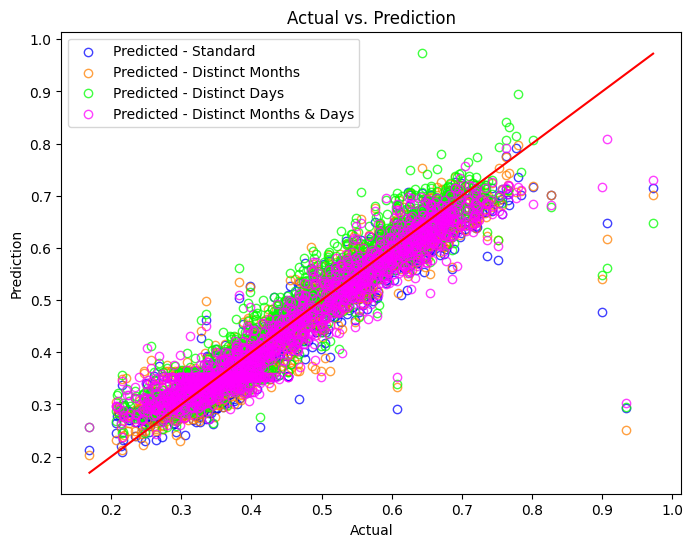

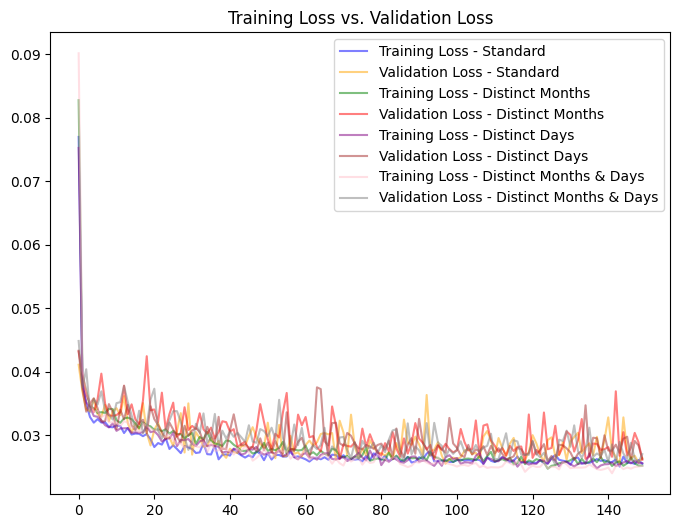

CPU times: user 4h 2min 31s, sys: 10min 11s, total: 4h 12min 42s
Wall time: 4h 30min 6s


,Model,Mean Absolute Error,Mean Error Squared,R-Squared,Adjusted R-Squared
0,Standard,0.025306,0.038536,0.920669,0.920030
1,Discrete Months,0.025666,0.038487,0.920870,0.919724
2,Discrete Day of the Week,0.026494,0.039799,0.915385,0.914407
3,Discrete Month And DOTW,0.026795,0.040659,0.911689,0.910098


In [6]:
%%time
std_nFeat = len(std_dataset.keys()) - 1
dm_nFeat = len(discrete_month_dataset.keys()) - 1
ddotw_nFeat = len(discrete_dotw_dataset.keys()) - 1
dmdotw_nFeat = len(discrete_month_dotw_dataset.keys()) - 1

best_stats = [[999,0,0,0], [999,0,0,0], [999,0,0,0], [999,0,0,0]]
best_train_loss = [0,0,0,0]
best_valid_loss = [0,0,0,0]
best_pred = [0,0,0,0]
best_actu = [0,0,0,0]

for i in range(40):
  std_train, std_test, dm_train, dm_test, ddotw_train, ddotw_test, dmdotw_train, dmdotw_test = generate_all_train_and_test_sets()
  std_model, dm_model, ddotw_model, dmdotw_model = generate_and_train_all_models(std_train, dm_train, ddotw_train, dmdotw_train, 150)

  std_train_loss = std_model.history.history['loss']
  std_valid_loss = std_model.history.history['val_loss']

  dm_train_loss = dm_model.history.history['loss']
  dm_valid_loss = dm_model.history.history['val_loss']

  ddotw_train_loss = ddotw_model.history.history['loss']
  ddotw_valid_loss = ddotw_model.history.history['val_loss']

  dmdotw_train_loss = dmdotw_model.history.history['loss']
  dmdotw_valid_loss = dmdotw_model.history.history['val_loss']

  std_pred, std_actu, dm_pred, dm_actu, ddotw_pred, ddotw_actu, dmdotw_pred, dmdotw_actu = pred_actu = get_all_model_predictions_and_actual(std_model, std_test, dm_model, dm_test, ddotw_model, ddotw_test, dmdotw_model, dmdotw_test)

  std_stats = evaluate_predicted_versus_actual(std_pred, std_actu, std_nFeat)
  dm_stats = evaluate_predicted_versus_actual(dm_pred, dm_actu, dm_nFeat)
  ddotw_stats = evaluate_predicted_versus_actual(ddotw_pred, ddotw_actu, ddotw_nFeat)
  dmdotw_stats = evaluate_predicted_versus_actual(dmdotw_pred, dmdotw_actu, dmdotw_nFeat)

  if(std_stats[0] < best_stats[0][0]):
    best_stats[0] = std_stats
    best_train_loss[0] = std_train_loss
    best_valid_loss[0] = std_valid_loss
    best_pred[0] = std_pred
    best_actu[0] = std_actu

  if(dm_stats[0] < best_stats[1][0]):
    best_stats[1] = dm_stats
    best_train_loss[1] = dm_train_loss
    best_valid_loss[1] = dm_valid_loss
    best_pred[1] = dm_pred
    best_actu[1] = dm_actu

  if(ddotw_stats[0] < best_stats[2][0]):
    best_stats[2] = ddotw_stats
    best_train_loss[2] = ddotw_train_loss
    best_valid_loss[2] = ddotw_valid_loss
    best_pred[2] = ddotw_pred
    best_actu[2] = ddotw_actu

  if(dmdotw_stats[0] < best_stats[3][0]):
    best_stats[3] = dmdotw_stats
    best_train_loss[3] = dmdotw_train_loss
    best_valid_loss[3] = dmdotw_valid_loss
    best_pred[3] = dmdotw_pred
    best_actu[3] = dmdotw_actu



plot_all_predicted_versus_actual(*pred_actu)
plot_all_training_versus_validation_loss(best_train_loss[0], best_valid_loss[0], best_train_loss[1], best_valid_loss[1], best_train_loss[2], best_valid_loss[2], best_train_loss[3], best_valid_loss[3], 150)

pd.DataFrame({"Model" : ["Standard", "Discrete Months", "Discrete Day of the Week", "Discrete Month And DOTW"],
              "Mean Absolute Error" : [best_stats[0][0], best_stats[1][0], best_stats[2][0], best_stats[3][0]],
              "Mean Error Squared" : [best_stats[0][1], best_stats[1][1], best_stats[2][1], best_stats[3][1]],
              "R-Squared" : [best_stats[0][2], best_stats[1][2], best_stats[2][2], best_stats[3][2]],
              "Adjusted R-Squared" : [best_stats[0][3], best_stats[1][3], best_stats[2][3], best_stats[3][3]]})

The dataset to produce the best model by a significant margin is the basic un-altered variant. Moving forward the standard model will be used, features will be removed one at a time to see if any have no impact or a negative impact upon the result.

In [7]:
%%time
adj_dataset = std_dataset.drop("prcp", axis=1)

best_stats = [999,0,0,0]

for i in range(10):
  std_train = adj_dataset.sample(frac=0.8, random_state=0)
  std_test = adj_dataset.drop(std_train.index)

  std_train_feat = std_train.copy()
  std_train_lab = std_train_feat.pop("reports")

  std_norm = tf.keras.layers.Normalization(axis=-1)
  std_norm.adapt(np.array(std_train_feat))

  std_layers = [std_norm, layers.Dense(units=65, activation="relu"), layers.Dense(units=65, activation="relu"), layers.Dense(units=1)]

  std_model = tf.keras.Sequential(std_layers)
  std_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MAE)

  std_model.fit(std_train_feat, std_train_lab, epochs=150, validation_split=0.1, verbose=0)

  std_train_loss = std_model.history.history['loss']
  std_valid_loss = std_model.history.history['val_loss']

  std_test_feat = std_test.copy()
  std_test_lab = std_test_feat.pop("reports")
  std_pred = std_model.predict(std_test_feat, verbose=0).flatten()

  stats = evaluate_predicted_versus_actual(std_pred, std_test_lab, len(std_test.keys()) - 1)

  if(stats[0] < best_stats[0]):
    best_stats = stats

print_evaluation_statistics(*best_stats)

Mean Absolute Error: 0.025561713523625375
Root Mean Squared Error: 0.03857122374351443
R-Squared: 0.9205246408674594
Adjusted R-Squared: 0.9199301761558811
CPU times: user 14min 56s, sys: 36.2 s, total: 15min 32s
Wall time: 15min 58s


No features were found that had a negative effect or no effect. Total precipitation was found to be the least impactful feature as shown with a slight increase in mean absolute error and root mean squared error when removed.

Another consideration to test is that the period around 2020 - 2022 is particularly out of the ordinary as explored in the analysis and as such an improvement may be made by removing this data.

In [8]:
adj_dataset = std_dataset.drop(std_dataset[(std_dataset.year > 2019) & (std_dataset.year < 2023)].index)

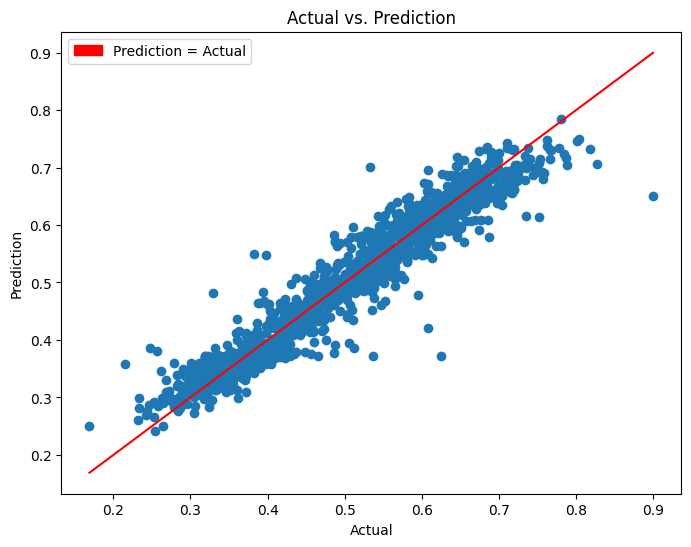

Mean Absolute Error: 0.024483435577073904
Root Mean Squared Error: 0.03387658749704231
R-Squared: 0.9339012867048743
Adjusted R-Squared: 0.9332916806534041


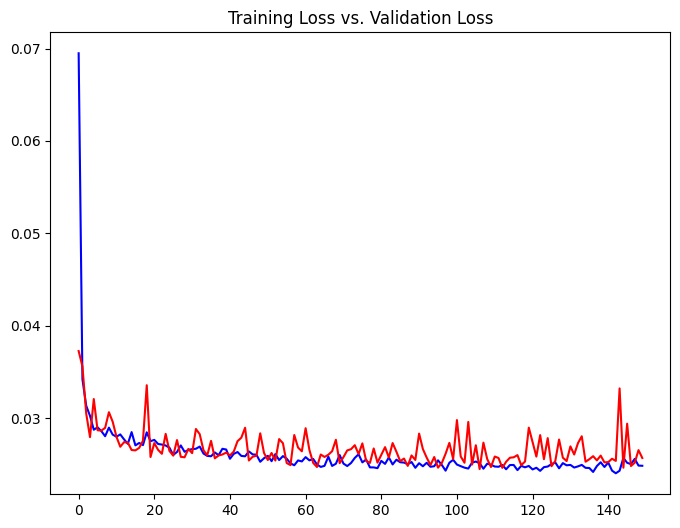

CPU times: user 9min 4s, sys: 20.7 s, total: 9min 25s
Wall time: 9min 52s


In [10]:
%%time
best_stats = [999,0,0,0]
best_loss = [0,0]
best_pred = 0
best_actu = 0

for i in range(6):
  std_train = adj_dataset.sample(frac=0.8, random_state=0)
  std_test = adj_dataset.drop(std_train.index)

  std_train_feat = std_train.copy()
  std_train_lab = std_train_feat.pop("reports")

  std_norm = tf.keras.layers.Normalization(axis=-1)
  std_norm.adapt(np.array(std_train_feat))

  std_layers = [std_norm, layers.Dense(units=65, activation="relu"), layers.Dense(units=65, activation="relu"), layers.Dense(units=1)]

  std_model = tf.keras.Sequential(std_layers)
  std_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MAE)

  std_model.fit(std_train_feat, std_train_lab, epochs=150, validation_split=0.1, verbose=0)

  std_train_loss = std_model.history.history['loss']
  std_valid_loss = std_model.history.history['val_loss']

  std_test_feat = std_test.copy()
  std_test_lab = std_test_feat.pop("reports")
  std_pred = std_model.predict(std_test_feat, verbose=0).flatten()

  stats = evaluate_predicted_versus_actual(std_pred, std_test_lab, len(std_test.keys()) - 1)

  if(stats[0] < best_stats[0]):
    best_stats = stats
    best_loss = [std_train_loss, std_valid_loss]
    best_pred = std_pred
    best_actu = std_test_lab

plot_predicted_versus_actual(best_pred, best_actu)
print_evaluation_statistics(*best_stats)
plot_training_versus_validation_loss(best_loss[0], best_loss[1], 150)

Removing the years 2020-2022 inclusively makes a significant improvement to the performance statistics generated for the model, additionally training loss drops very quickly in the first 10 epochs as compared to about 40 epochs in previous models and there is less noise in the plots. A final model will be found by modifying the parameters of the model such as:
- Epochs
- Number of hidden layers
- Nodes per layer
- Activation function

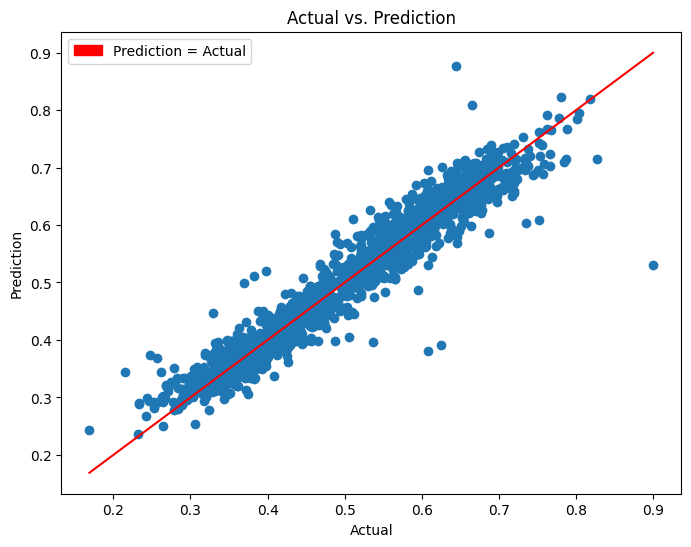

Mean Absolute Error: 0.023747589476094247
Root Mean Squared Error: 0.03346927522430334
R-Squared: 0.9354811958404686
Adjusted R-Squared: 0.9348861607559934


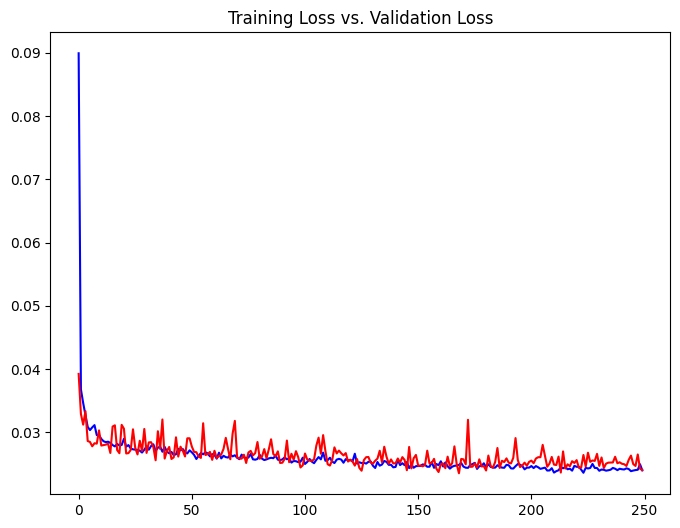

CPU times: user 7min 9s, sys: 16.5 s, total: 7min 26s
Wall time: 7min 57s


In [11]:
%%time
best_stats = [999,0,0,0]
best_loss = [0,0]
best_pred = 0
best_actu = 0
epochs = 250

for i in range(3):
  train = adj_dataset.sample(frac=0.8, random_state=0)
  test = adj_dataset.drop(train.index)

  train_feat = train.copy()
  train_lab = train_feat.pop("reports")

  norm = tf.keras.layers.Normalization(axis=-1)
  norm.adapt(np.array(train_feat))

  model_layers = [norm, layers.Dense(units=15, activation=tf.keras.activations.relu), layers.Dense(units=9, activation=tf.keras.activations.relu), layers.Dense(units=5, activation=tf.keras.activations.relu), layers.Dense(units=1)]

  model = tf.keras.Sequential(model_layers)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.008), loss=keras.losses.MAE)

  model.fit(train_feat, train_lab, epochs=epochs, validation_split=0.1, verbose=0)

  train_loss = model.history.history['loss']
  valid_loss = model.history.history['val_loss']

  test_feat = test.copy()
  test_lab = test_feat.pop("reports")
  pred = model.predict(test_feat, verbose=0).flatten()

  stats = evaluate_predicted_versus_actual(pred, test_lab, len(test.keys()) - 1)

  if(stats[0] < best_stats[0]):
    best_stats = stats
    best_loss = [train_loss, valid_loss]
    best_pred = pred
    best_actu = test_lab

plot_predicted_versus_actual(best_pred, best_actu)
print_evaluation_statistics(*best_stats)
plot_training_versus_validation_loss(best_loss[0], best_loss[1], epochs)

- The best model configuration was found to have 4 layers with 15, 9, 5 and 1 neurons for each layer respectively.
- The relu activation function was found to be the best with celu being a close second.
- The combination of 250 epochs and a learning rate of 0.08 was found to be a good compromise to produce the optimal model without overfitting the data.

To find a reasonable best model using this configuration the training and test datasets are generated 40 times and models are trained, statistics are compared to select the best model.

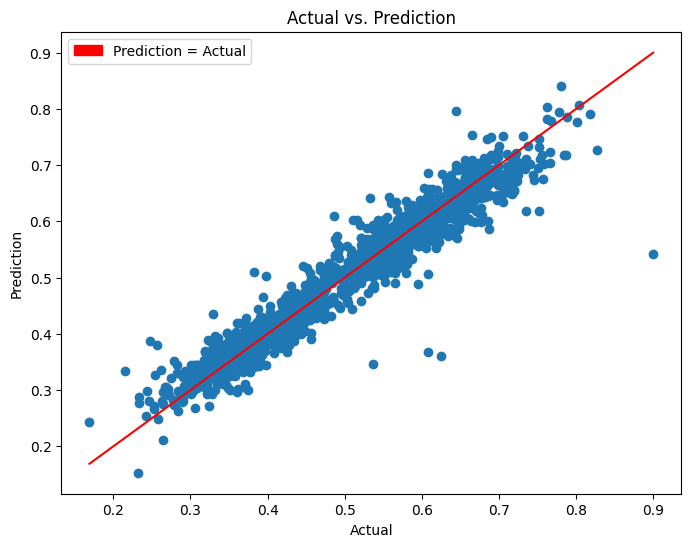

Mean Absolute Error: 0.023419033714456687
Root Mean Squared Error: 0.03315842948159437
R-Squared: 0.9366740668103833
Adjusted R-Squared: 0.9360900331709534


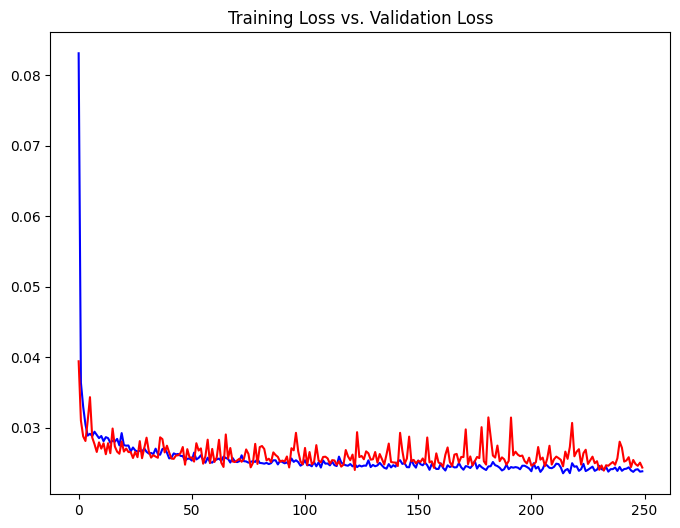

CPU times: user 1h 30min 20s, sys: 3min 32s, total: 1h 33min 52s
Wall time: 1h 43min 9s


In [12]:
%%time
best_stats = [999,0,0,0]
best_loss = [0,0]
best_pred = 0
best_actu = 0
epochs = 250

for i in range(40):
  train = adj_dataset.sample(frac=0.8, random_state=0)
  test = adj_dataset.drop(train.index)

  train_feat = train.copy()
  train_lab = train_feat.pop("reports")

  norm = tf.keras.layers.Normalization(axis=-1)
  norm.adapt(np.array(train_feat))

  model_layers = [norm, layers.Dense(units=15, activation=tf.keras.activations.relu), layers.Dense(units=9, activation=tf.keras.activations.relu), layers.Dense(units=5, activation=tf.keras.activations.relu), layers.Dense(units=1)]

  model = tf.keras.Sequential(model_layers)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.008), loss=keras.losses.MAE)

  model.fit(train_feat, train_lab, epochs=epochs, validation_split=0.1, verbose=0)

  train_loss = model.history.history['loss']
  valid_loss = model.history.history['val_loss']

  test_feat = test.copy()
  test_lab = test_feat.pop("reports")
  pred = model.predict(test_feat, verbose=0).flatten()

  stats = evaluate_predicted_versus_actual(pred, test_lab, len(test.keys()) - 1)

  if(stats[0] < best_stats[0]):
    best_stats = stats
    best_loss = [train_loss, valid_loss]
    best_pred = pred
    best_actu = test_lab

plot_predicted_versus_actual(best_pred, best_actu)
print_evaluation_statistics(*best_stats)
plot_training_versus_validation_loss(best_loss[0], best_loss[1], epochs)

## Conclusion
Both a linear model and DNN model can be used to reasonably accurately predict the number of crimes reported on a given day. The DNN model performs significantly better producing slightly over half of the mean absolute error comparatively when converted into the same units.

In [18]:
pd.DataFrame(
    {
        "Model" : ["Linear Regression", "Deep Neural Network"],
        "Mean Absolute Error" : [85.91506496412025 , 0.023419033714456687 * max_reports],
        "Root Mean Squared Error" : [114.65940752383976 , 0.03315842948159437 * max_reports],
        "Adjusted R-Squared" : [0.8295353942989154, 0.9360900331709534]
    }
)

,Model,Mean Absolute Error,Root Mean Squared Error,Adjusted R-Squared
0,Linear Regression,85.915065,114.659408,0.829535
1,Deep Neural Network,47.657734,67.477404,0.936090


The linear model is less complex however the DNN model will generally significantly outperform it. The difference in configuration time is unlikely to be a significant factor in choosing a model as this can be done offline.

There is some noise in the training and validation loss plots for the DNN, however, they do follow each other and similar error statistics are produced when the model is used on seperate unseen data eliminating the concern of over-fitting. The main effect that this has is that multiple models should be trained and the best selected to avoid producing an under-performing model, however this would be advisable when producing a linear model as well.

Overall the deep neural network would be my choice of models for this application as the benefits far outweigh the negatives.